<a href="https://colab.research.google.com/github/daaffalbari/10120212-DAFFA-ALBARI-IF6/blob/main/OPet_Classification_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dogs and Cats Breeds Classifier


> Dataset: https://www.robots.ox.ac.uk/~vgg/data/pets/



## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [2]:
print("\u2022 Using TensorFlow Version:", tf.__version__)
print("\u2022 Using TensorFlow Hub Version: ", hub.__version__)

• Using TensorFlow Version: 2.12.0
• Using TensorFlow Hub Version:  0.13.0


## Import Data

### Load and Split the raw image data
Dividing the train split of this dataset into (train, val, test) with 90, 5, 5 of the data respectively

In [3]:
(train_raw, val_raw, test_raw), ds_info = tfds.load (
                                          name='oxford_iiit_pet',
                                          split=['train[:90%]', 'train[90%:]', 'test'], 
                                          shuffle_files=True,
                                          as_supervised=True,
                                          with_info=True
                                        )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete30Y3MY/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete30Y3MY/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
ds_info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path=PosixGPath('/tmp/tmp6d6dpvx9tfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        

### Menampilkan beberapa dataset

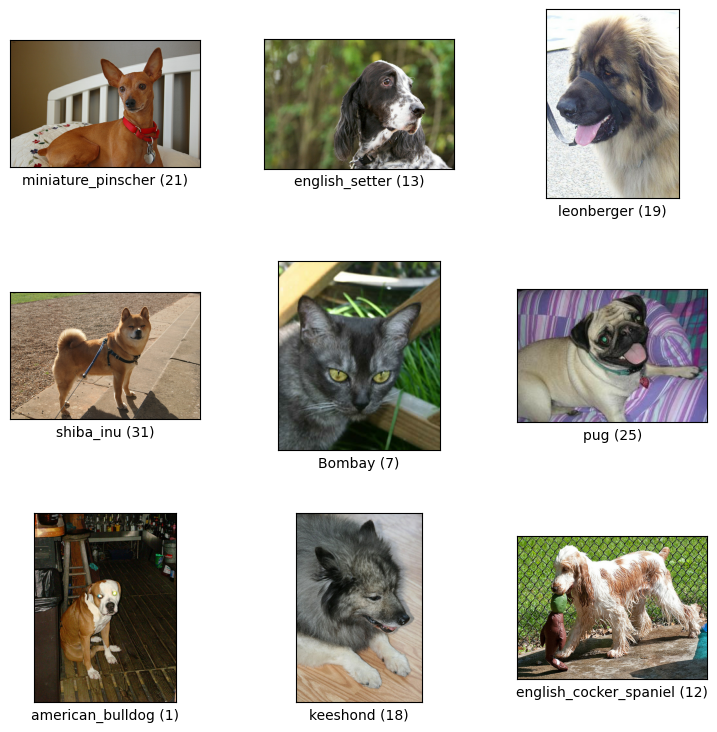

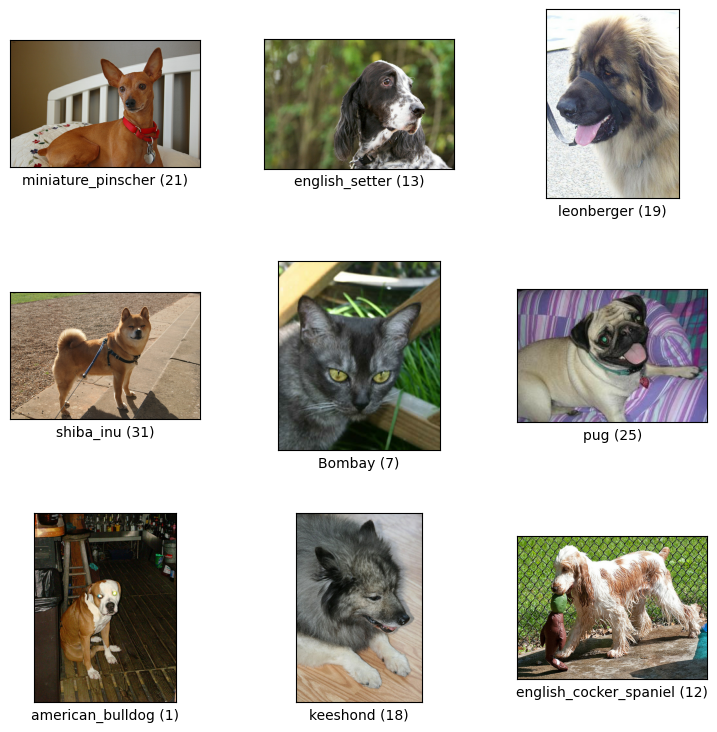

In [5]:
tfds.show_examples(train_raw, ds_info, image_key='image', label_key='label')

### Understanding the dataset

In [6]:
# Menampilkan jumlah kelas
num_classes = ds_info.features['label'].num_classes
print(f"Jumlah Class : {num_classes}")

Jumlah Class : 37


In [7]:
# Menampilkan Nama-nama kelas
name_classes = ds_info.features['label'].names
print(name_classes)

['Abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'Bengal', 'Birman', 'Bombay', 'boxer', 'British_Shorthair', 'chihuahua', 'Egyptian_Mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'Maine_Coon', 'miniature_pinscher', 'newfoundland', 'Persian', 'pomeranian', 'pug', 'Ragdoll', 'Russian_Blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'Siamese', 'Sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


In [8]:
# Info datasets
num_train_examples = tf.data.experimental.cardinality(train_raw).numpy()
num_val_examples = tf.data.experimental.cardinality(val_raw).numpy()
num_test_examples = tf.data.experimental.cardinality(test_raw).numpy()

print(f"Jumlah Data Training: {num_train_examples}")
print(f"Jumlah Data Validation: {num_val_examples}")
print(f"Jumlah Data Testing: {num_test_examples}")

Jumlah Data Training: 3312
Jumlah Data Validation: 368
Jumlah Data Testing: 3669


In [9]:
# Mendapatkan label dari data
get_label_name = ds_info.features['label'].int2str

In [10]:
def view_single_image(ds):
    image, label = next(iter(ds))
    print('Image shape: ', image.shape)
    plt.imshow(image)
    _ = plt.title(get_label_name(label))

Image shape:  (500, 500, 3)


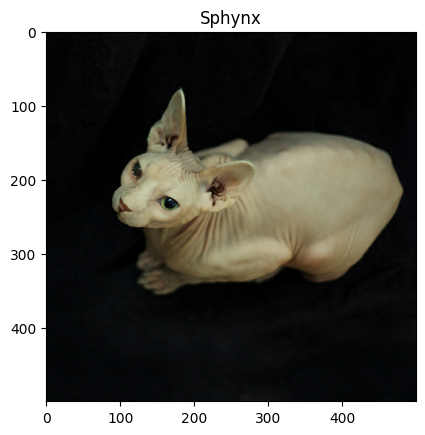

In [11]:
view_single_image(train_raw)

## Data Preparation

### Image Resizing

In [12]:
IMG_SIZE = 299

train_ds = train_raw.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y))
val_ds = val_raw.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y))
test_ds = test_raw.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y))

### Label one-hot encoding

In [13]:
def one_hot_encode(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [14]:
train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)
test_ds = test_ds.map(one_hot_encode)

In [15]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip('horizontal'), 
    #  layers.RandomRotation(factor=(-0.025, 0.025)),
    #  layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    #  layers.RandomContrast(factor=0.1),
     ])

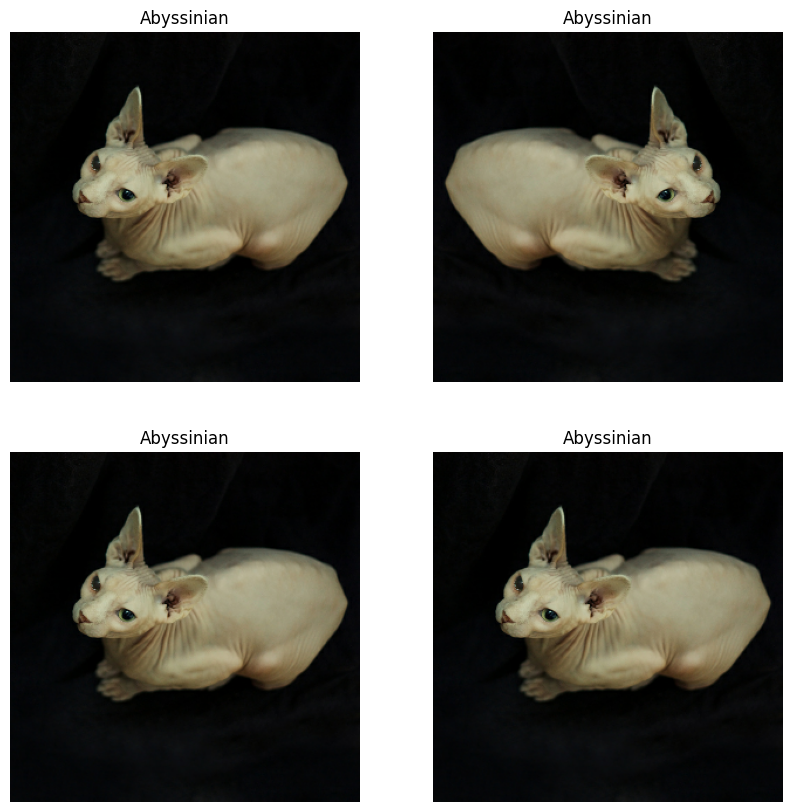

In [16]:
for image, label in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(4):
        ax = plt.subplot(2, 2, i+1)
        aug_img = data_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title(get_label_name(int(label[0])))
        plt.axis("off")

In [17]:
BATCH_SIZE = 32

### Batching and prefetching

In [18]:
train_ds = train_ds.batch(batch_size=BATCH_SIZE, 
                          drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.batch(batch_size=BATCH_SIZE, 
                      drop_remainder=True).prefetch(tf.data.AUTOTUNE)
                      
test_ds = test_ds.batch(batch_size=BATCH_SIZE, 
                        drop_remainder=True).prefetch(tf.data.AUTOTUNE)

## Defining The model

In [19]:
def getModel(dropout=0.25):
  # setup base model
  base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

  # Freeze  pre-trained weight of the base mode
  base_model.trainable = False

  # input layers
  inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
  x = inputs

  # pass inputs to a process layer
  x = tf.keras.applications.inception_v3.preprocess_input(x)
  x = base_model(x, training=False)

  # Rebuild top layers
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(dropout)(x)
  x = tf.keras.layers.Dense(64, activation='relu')(x)
  outputs = tf.keras.layers.Dense(37, activation='softmax')(x)

  model = tf.keras.Model(inputs, outputs)

  # Display model summary
  model.summary()

  # Compile model
  model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=[keras.metrics.CategoricalAccuracy()])

  return model


In [20]:
# Prevent overfitting
earlystopping = callbacks.EarlyStopping(monitor='val_loss', 
                                        mode='min', 
                                        patience=5, 
                                        restore_best_weights=True)

### Model Training

In [21]:
model = getModel()

# Fit Model
history = model.fit(
    train_ds, 
    epochs = 25,
    validation_data=val_ds,
    verbose=1,
    callbacks = [earlystopping]
)

87910968/87910968 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                       

### Plot The accuracy of training and validation sets over epochs

Text(0.5, 1.0, 'Training and validation loss')

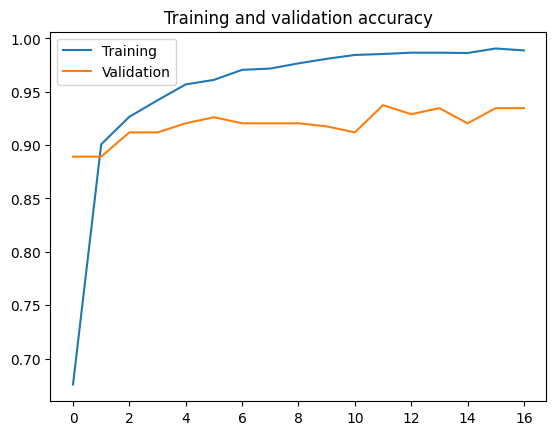

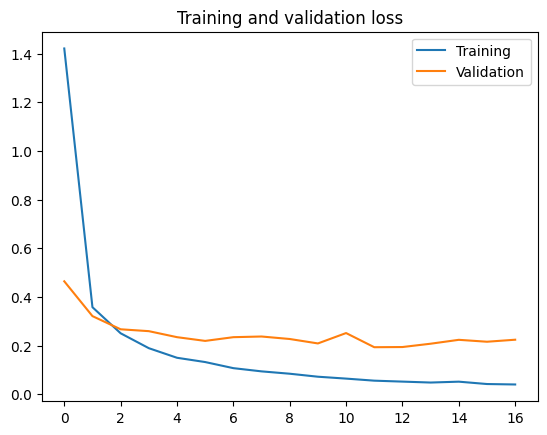

In [22]:
acc      = history.history[     'categorical_accuracy' ]
val_acc  = history.history[ 'val_categorical_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc, label='Training')
plt.plot  ( epochs, val_acc, label='Validation')
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, label='Training')
plt.plot  ( epochs, val_loss, label='Validation')
plt.legend()
plt.title ('Training and validation loss')

## Model Evaluation

In [23]:
preds = model.predict(test_ds)

114/114 [==============================] - 21s 165ms/step


In [24]:
# Evaluate model on test dataset
result = model.evaluate(test_ds)


114/114 [==============================] - 19s 162ms/step - loss: 0.3060 - categorical_accuracy: 0.9115


In [25]:
# Display result
dict(zip(model.metrics_names, result))

{'loss': 0.3059622347354889, 'categorical_accuracy': 0.9114583134651184}

In [26]:
type(preds)

numpy.ndarray

In [27]:
print(result)

[0.3059622347354889, 0.9114583134651184]


## Finetune Model

In [28]:
# Unfreeze base model
for layer in model.layers[-15:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

In [29]:
# Recompile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), # Set a very low learning rate
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()]
             )

In [30]:
# Retrain model
EPOCHS = 5

history_2 = model.fit(train_ds, 
                      epochs=EPOCHS, 
                      validation_data=val_ds, 
                      verbose=1,
                      callbacks =[earlystopping])

Epoch 1/5
103/103 [==============================] - 95s 471ms/step - loss: 0.0558 - categorical_accuracy: 0.9815 - val_loss: 0.2250 - val_categorical_accuracy: 0.9318
Epoch 2/5
103/103 [==============================] - 48s 461ms/step - loss: 0.0233 - categorical_accuracy: 0.9933 - val_loss: 0.2135 - val_categorical_accuracy: 0.9375
Epoch 3/5
103/103 [==============================] - 47s 456ms/step - loss: 0.0139 - categorical_accuracy: 0.9951 - val_loss: 0.2160 - val_categorical_accuracy: 0.9432
Epoch 4/5
103/103 [==============================] - 48s 462ms/step - loss: 0.0075 - categorical_accuracy: 0.9988 - val_loss: 0.2416 - val_categorical_accuracy: 0.9375
Epoch 5/5
103/103 [==============================] - 47s 453ms/step - loss: 0.0081 - categorical_accuracy: 0.9979 - val_loss: 0.2182 - val_categorical_accuracy: 0.9318


In [31]:
preds2 = model.predict(test_ds)

114/114 [==============================] - 20s 165ms/step


In [32]:
# Display fine-tuned model result
result_2 = model.evaluate(test_ds)

dict(zip(model.metrics_names, result_2))

114/114 [==============================] - 19s 164ms/step - loss: 0.3456 - categorical_accuracy: 0.9252


{'loss': 0.3455808162689209, 'categorical_accuracy': 0.9251644611358643}

## Export The Model

In [35]:
OPET_SAVED_MODEL = "opet_saved_model"


#### Export the savedModel

In [36]:
tf.saved_model.save(model, OPET_SAVED_MODEL)

In [37]:
%%bash -s $OPET_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['input_2'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 299, 299, 3)
      name: serving_default_input_2:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 37)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


2023-06-03 21:19:29.756844: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [38]:
loaded = tf.saved_model.load(OPET_SAVED_MODEL)

In [39]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'input_2': TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='input_2')})
{'dense_1': TensorSpec(shape=(None, 37), dtype=tf.float32, name='dense_1')}


### Convert using tflite

In [40]:
converter = tf.lite.TFLiteConverter.from_saved_model(OPET_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

In [41]:
saved_model_path = "opet_model.h5"


model.save(saved_model_path)
!tensorflowjs_converter --input_format=keras {saved_model_path} ./

/bin/bash: tensorflowjs_converter: command not found


In [42]:
tflite_model_file = 'opet_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

### Test TFLite Model using the python interpreter

In [44]:
# Load TFLite model and allocate tensors.
with open(tflite_model_file, 'rb') as fid:
    tflite_model = fid.read()
    
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [45]:
# Gather results for the randomly sampled test images
from tqdm import tqdm


predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_ds.take(10)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

  0%|          | 0/10 [00:00<?, ?it/s]


ValueError: ignored

In [46]:
class_names = [
    "Abyssinian",
    "american_bulldog",
    "american_pit_bull_terrier",
    "basset_hound",
    "beagle",
    "Bengal",
    "Birman",
    "Bombay",
    "boxer",
    "British_Shorthair",
    "chihuahua",
    "Egyptian_Mau",
    "english_cocker_spaniel",
    "english_setter",
    "german_shorthaired",
    "great_pyrenees",
    "havanese",
    "japanese_chin",
    "keeshond",
    "leonberger",
    "Maine_Coon",
    "miniature_pinscher",
    "newfoundland",
    "Persian",
    "pomeranian",
    "pug",
    "Ragdoll",
    "Russian_Blue",
    "saint_bernard",
    "samoyed",
    "scottish_terrier",
    "shiba_inu",
    "Siamese",
    "Sphynx",
    "staffordshire_bull_terrier",
    "wheaten_terrier",
    "yorkshire_terrier",
]

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    print(type(predicted_label), type(true_label))
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
        
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

IndexError: ignored

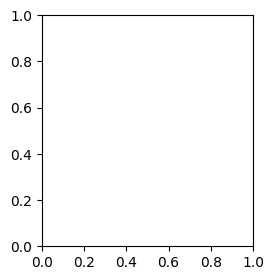

In [47]:
index = 1 #@param {type:"slider", min:0, max:9, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()

In [ ]:
from google.colab import drive
drive.mount('drive')

!cp labels.txt "/content/drive/MyDrive/"
!cp converted_model.tflite "/content/drive/MyDrive"

Mounted at drive


In [ ]:
interpreter = tf.lite.Interpreter(model_path="/content/gdrive/MyDrive/converted_model.tflite")
interpreter.allocate_tensors()

# Print input shape and type
inputs = interpreter.get_input_details()
print('{} input(s):'.format(len(inputs)))
for i in range(0, len(inputs)):
    print('{} {}'.format(inputs[i]['shape'], inputs[i]['dtype']))

# Print output shape and type
outputs = interpreter.get_output_details()
print('\n{} output(s):'.format(len(outputs)))
for i in range(0, len(outputs)):
    print('{} {}'.format(outputs[i]['shape'], outputs[i]['dtype']))

ValueError: ignored